In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.optimizers import RMSprop, Adam

from matplotlib import pyplot as plt
import numpy as np

In [47]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         x = tf.random.uniform((batch_size,1),
                      minval=tf.constant(-1.0, dtype=tf.float32),
                      maxval=tf.constant( 1.0, dtype=tf.float32),
                      dtype=tf.float32)

         with tf.GradientTape() as tape:
             pi = tf.constant(np.pi, dtype=x.dtype)
             f = 3.0 * tf.math.sin(pi * x)
             y = self(x, training=True)
             eq = y - f
             loss = self.mse(tf.zeros_like(eq), eq)

        # Apply grads
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
         return {"loss": self.loss_tracker.result()}

In [48]:
mse = tf.keras.losses.MeanSquaredError()
mse([[3],[5]], [[2],[1]])

<tf.Tensor: shape=(), dtype=float32, numpy=8.5>

In [69]:
tf.keras.backend.clear_session()
model = ODEsolver()

model.add(Dense(32, activation='tanh', input_shape=(1,)))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

model.summary()

Model: "od_esolver"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

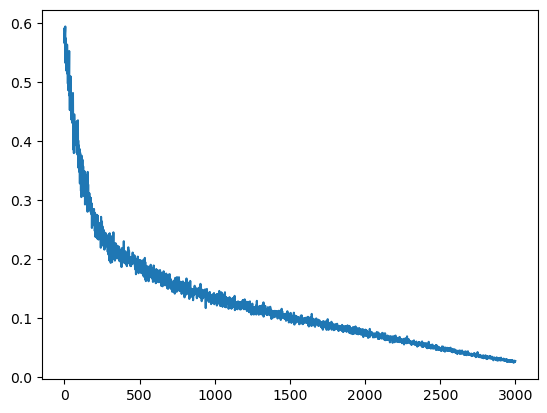

In [72]:
#model.compile(optimizer=RMSprop(),metrics=['loss'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4))
x=tf.linspace(-1.0,1.0,1024)[:, None]
x = tf.cast(x, tf.float32)
history = model.fit(x,epochs=3000, batch_size=1024, verbose=0)
plt.plot(history.history["loss"])

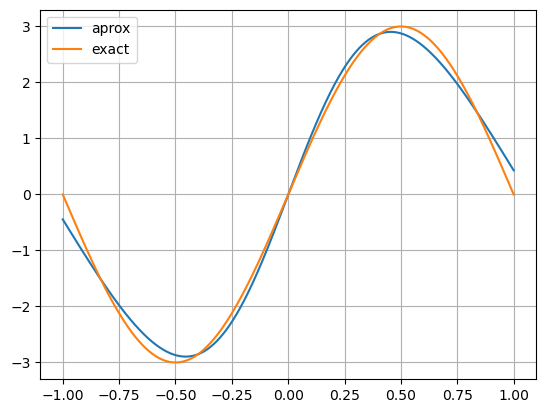

In [73]:
x_testv = tf.linspace(-1,1,1024)
x_testv = tf.cast(x_testv, tf.float32)[:, None]
x_np = x_testv.numpy().ravel()
a=model(x_testv, training = False).numpy().ravel()
y_true = 3.0 * np.sin(np.pi * x_np)
plt.plot(x_np, a, label="aprox")
plt.plot(x_np, y_true,label="exact")
plt.legend()
plt.grid(True)
plt.show()